In [1]:
import numpy as np

class Value:
    def __init__(self, func=None):
        self.func = func
        self.value = None

    def compute(self):
        if self.func:
            self.func.compute()

    def diff(self, D):
        if self.func:
            self.func.diff(D)

class Func:
    def __call__(self, *inputs):
        self.inputs = inputs
        self.output = Value(self)
        return self.output

    def compute(self):
        pass

    def diff(self, D):
        pass

In [2]:
class LeakyReLU(Func):
    def __init__(self, slope):
        self.slope = slope

    def compute(self):
        x = self.inputs[0]
        x.compute()
        self.output.value = np.where(
            x.value > 0, x.value, x.value * self.slope
        )

    def diff(self, D):
        _D = np.where(self.output.value > 0, 1.0, self.slope).T
        self.inputs[0].diff(D * _D)

class Linear(Func):
    rng = np.random.default_rng()
    
    def __init__(self, m, n):
        self.W = self.rng.random((m, n))
        self.b = self.rng.random((m, 1))

    def compute(self):
        x = self.inputs[0]
        x.compute()
        self.output.value = self.W @ x.value + self.b

    def diff(self, D):
        self.inputs[0].diff(D @ self.W)
        self.W -= D.T @ self.inputs[0].value.T
        self.b -= D.T

In [3]:
from tqdm import tqdm
import random

def f_target(x, y):
    return np.arcsin(x * y) + np.sin(0.2**x + 5 * y)

L1 = Linear(10, 2)
R1 = LeakyReLU(0.01)
L2 = Linear(50, 10)
R2 = LeakyReLU(0.01)
L3 = Linear(10, 50)
R3 = LeakyReLU(0.01)
L4 = Linear(1, 10)

X = Value()
Y = L4(R3(L3(R2(L2(R1(L1(X)))))))

def f_approx(x, y):
    X.value = np.array([[x, y]]).T
    Y.compute()
    return Y.value[0][0]

samples = []
for i in range(10000):
    x0 = random.uniform(-1, 1)
    x1 = random.uniform(-1, 1)
    samples.append((x0, x1, f_target(x0, x1)))

rate = 0.001
steps = 10000000

for i in tqdm(range(steps)):
    x0, x1, y = random.choice(samples)
    d = f_approx(x0, x1) - y
    Y.diff(np.array([[(d / np.abs(d)) * rate]]))

100%|████████████████████████████| 10000000/10000000 [05:20<00:00, 31225.87it/s]


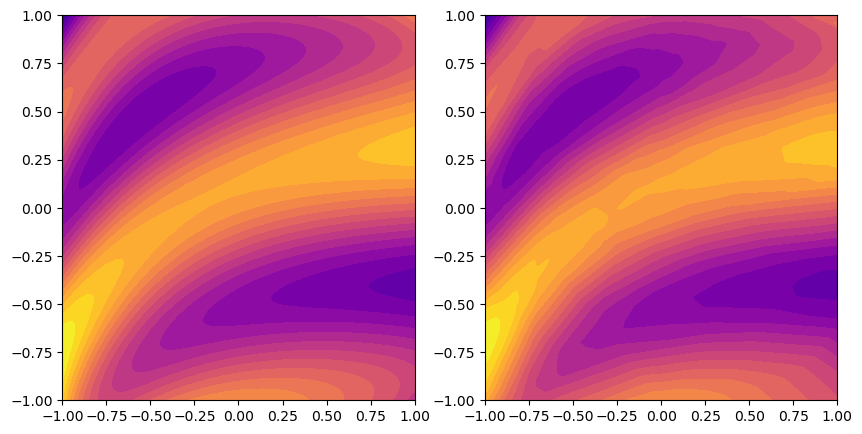

In [4]:
import matplotlib.pyplot as plt

def plot(f1, f2, lower, upper, levels):
    X, Y = np.meshgrid(
        np.linspace(lower, upper, 256), np.linspace(lower, upper, 256)
    )
    Z1 = np.vectorize(f1)(X, Y)
    Z2 = np.vectorize(f2)(X, Y)
    levels = np.linspace(Z1.min(), Z1.max(), levels)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.contourf(X, Y, Z1, levels=levels, cmap="plasma")
    ax2.contourf(X, Y, Z2, levels=levels, cmap="plasma")
    plt.show()

plot(f_target, f_approx, lower=-1, upper=1, levels=20)